<a href="https://colab.research.google.com/github/se00un/Guide_Project/blob/main/%EA%B0%80%EC%9D%B4%EB%93%9C%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EC%83%81%EA%B4%80%EA%B4%80%EA%B3%84%EB%B6%84%EC%84%9D_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 가이드프로젝트

In [ ]:
# 코랩환경에서만 사용
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pandas, numpy import
# tqdm, random, os 는 필요시 import
import pandas as pd #Analysis
import numpy as np
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


SEED = 42

In [ ]:
reset_seeds(SEED)

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.4 MB/s eta 0:00:00


In [ ]:
# 모델 관련 library import
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings
import joblib
warnings.filterwarnings('ignore')

In [ ]:
# version 확인(대회용) - 선택사항
import sklearn,xgboost,lightgbm,catboost,sys,platform
print("numpy_version:",np.__version__)
print("pandas_version:",pd.__version__)
print("sklearn_version:",sklearn.__version__)
print("xgboost_version:",xgboost.__version__)
print("lightgbm_version:",lightgbm.__version__)
print("catboost_version:",catboost.__version__)
print(f"python_version: {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")
print("OS :",platform.platform())

numpy_version: 1.25.2
pandas_version: 1.5.3
sklearn_version: 1.2.2
xgboost_version: 2.0.3
lightgbm_version: 4.1.0
catboost_version: 1.2.3
python_version: 3.10.12
OS : Linux-6.1.58+-x86_64-with-glibc2.35


## 데이터 불러오기

In [ ]:
train_df = pd.read_csv('https://raw.githubusercontent.com/Jungj1won/GUIDE_PROJECT/main/train.csv')
train_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [ ]:
# train, test 불러오기
test_df = pd.read_csv('https://raw.githubusercontent.com/Jungj1won/GUIDE_PROJECT/main/test.csv')
test_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77


In [ ]:
# building_info 불러오기
building_info = pd.read_csv('https://raw.githubusercontent.com/Jungj1won/GUIDE_PROJECT/main/building_info.csv')
building_info.head()

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


# Train, Test 일시 컬럼 전처리
### 일시 컬럼을 확인해보면 20220601 00 으로 입력되어 있음
### 월, 주, 요일, 시간으로 분리해보기


#### datetime 혹은 isocalender 이용해보기

In [ ]:
# train data 일시 컬럼 수정
date = pd.to_datetime(train_df['일시'])
train_df['hour'] = date.dt.hour
train_df['day'] = date.dt.weekday
train_df['month'] = date.dt.month
train_df['week'] = date.dt.weekofyear

In [ ]:
# test data 일시 컬럼 수정
date = pd.to_datetime(test_df['일시'])
test_df['hour'] = date.dt.hour
test_df['day'] = date.dt.weekday
test_df['month'] = date.dt.month
test_df['week'] = date.dt.weekofyear

## building_info 전처리

In [ ]:
building_info

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000
...,...,...,...,...,...,...,...
95,96,호텔및리조트,93314.00,60500.00,-,-,-
96,97,호텔및리조트,55144.67,25880.00,-,-,-
97,98,호텔및리조트,53578.62,17373.75,-,-,-
98,99,호텔및리조트,53499.00,40636.00,-,-,-


### 데이터 확인해보면 결측치가 NA도 0 도아닌 '-'로 되어있음을 확인할 수 있음
### 0 혹은 NA로 변경해보기

In [ ]:
cols = ['태양광용량(kW)','ESS저장용량(kWh)','PCS용량(kW)']
for col in cols :
    building_info[col] = building_info[col].apply(lambda x : 0 if x =='-' else float(x))
building_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    float64
 5   ESS저장용량(kWh)  100 non-null    float64
 6   PCS용량(kW)     100 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 5.6+ KB


# Train 데이터 결측치 처리

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
 10  hour           204000 non-null  int64  
 11  day            204000 non-null  int64  
 12  month          204000 non-null  int64  
 13  week           204000 non-null  int64  
dtypes: float64(7), int64(5), object(2)
memory usage: 21.8+ MB


In [ ]:
test_df.info() # 결측치 없음.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   건물번호           16800 non-null  int64  
 2   일시             16800 non-null  object 
 3   기온(C)          16800 non-null  float64
 4   강수량(mm)        16800 non-null  float64
 5   풍속(m/s)        16800 non-null  float64
 6   습도(%)          16800 non-null  int64  
 7   hour           16800 non-null  int64  
 8   day            16800 non-null  int64  
 9   month          16800 non-null  int64  
 10  week           16800 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 1.4+ MB


In [ ]:
# train 데이터와 test 데이터간 컬럼이 다름
# 불필요한 컬럼 제거
train_ft = train_df.drop(columns=['일시','일조(hr)', '일사(MJ/m2)'])
test_ft = test_df.drop(columns=['일시'])

In [ ]:
# train 강수량 컬럼 채우기
train_ft['강수량(mm)']= train_ft['강수량(mm)'].fillna(0)

풍속, 습도 결측치 위치 확인

In [ ]:
train_ft[train_ft['풍속(m/s)'].isnull()]

,num_date_time,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh),hour,day,month,week
16643,9_20220614 11,9,17.6,0.0,NaN,NaN,2330.40,11,1,6,24
30161,15_20220806 17,15,35.6,0.0,NaN,NaN,1815.57,17,5,8,31
32127,16_20220803 15,16,30.4,0.0,NaN,77.0,5062.08,15,2,8,31
51640,26_20220627 16,26,27.2,3.1,NaN,93.0,5330.40,16,0,6,26
51921,26_20220709 09,26,26.3,0.0,NaN,84.0,2908.80,9,5,7,27
84418,42_20220703 10,42,29.8,0.0,NaN,66.0,3038.76,10,6,7,26
100738,50_20220703 10,50,29.8,0.0,NaN,66.0,3044.70,10,6,7,26
105639,52_20220806 15,52,33.4,0.0,NaN,72.0,2260.20,15,5,8,31
105640,52_20220806 16,52,33.5,0.0,NaN,73.0,2274.30,16,5,8,31
176477,87_20220714 05,87,21.9,0.0,NaN,NaN,519.66,5,3,7,28


In [ ]:
# 결측치 채우기 위해 특정 조건의 풍속 분포 확인
train_ft[(train_ft['건물번호']==9)&(train_ft['month']==6) & (train_ft['hour'] ==11)]['풍속(m/s)'].describe()

count    29.000000
mean      2.941379
std       1.144090
min       1.300000
25%       2.200000
50%       2.600000
75%       3.500000
max       5.900000
Name: 풍속(m/s), dtype: float64

In [ ]:
# 풍속 결측치 채우기
# 같은 건물, 같은 월, 같은 시간 기준으로 평균내서 결측치 채우기
for i in train_ft[train_ft['풍속(m/s)'].isnull()].index:
    # display(train_ft.iloc[i])
    month = train_ft.iloc[i]['month']
    hour = train_ft.iloc[i]['hour']
    num = train_ft.iloc[i]['건물번호']
    data_mean = train_ft[(train_ft['건물번호']==num)&(train_ft['month']==month) & (train_ft['hour'] ==hour)]['풍속(m/s)'].describe()['mean']
    train_ft.loc[i,'풍속(m/s)'] = data_mean

In [ ]:
# 결측치 없어진 것 확인
train_ft['풍속(m/s)'].isnull().sum()

0

In [ ]:
train_ft[(train_ft['month']==6) & (train_ft['hour'] ==11)]['습도(%)'].describe()

count    2999.000000
mean       66.573525
std        17.162310
min        19.000000
25%        53.000000
50%        66.000000
75%        80.000000
max       100.000000
Name: 습도(%), dtype: float64

In [ ]:
# 습도도 같은 방법으로 진행
for i in train_ft[train_ft['습도(%)'].isnull()].index:
    # display(train_ft.iloc[i])
    month = train_ft.iloc[i]['month']
    hour = train_ft.iloc[i]['hour']
    num = train_ft.iloc[i]['건물번호']
    data_mean = train_ft[(train_ft['건물번호']==num)&(train_ft['month']==month) & (train_ft['hour'] ==hour)]['습도(%)'].describe()['mean']
    train_ft.loc[i,'습도(%)'] = data_mean

In [ ]:
train_ft['습도(%)'].isnull().sum()

0

# 빌딩 info 합해주기

In [ ]:
# train 과 test에 건물번호로 테이블 합쳐주기
train_ft = train_ft.merge(building_info,how='left',on='건물번호')
test_ft = test_ft.merge(building_info,how='left',on='건물번호')

# 범주형 인코딩
### 확인해보면 건물유형이 한글로 되어 있어서 범주형으로 변경해주어야 함

In [ ]:
# mapping 할 dictionary 생성
conv_dict = dict(zip(list(train_ft['건물유형'].unique()), [0,1,2,3,4,5,6,7,8,9,10,11]))
conv_dict


# 건물 유형별 인사이트 도출: 전력 사용량, 기본적 풍속... 등등 인사이트 도출


{'건물기타': 0,
 '공공': 1,
 '대학교': 2,
 '데이터센터': 3,
 '백화점및아울렛': 4,
 '병원': 5,
 '상용': 6,
 '아파트': 7,
 '연구소': 8,
 '지식산업센터': 9,
 '할인마트': 10,
 '호텔및리조트': 11}

In [ ]:
# mapping
train_ft['건물유형'] = train_ft['건물유형'].map(conv_dict)
test_ft['건물유형'] = test_ft['건물유형'].map(conv_dict)

# target 설정

In [ ]:
target = train_df['전력소비량(kWh)']
target

0         1085.28
1         1047.36
2          974.88
3          953.76
4          986.40
           ...   
203995     881.04
203996     798.96
203997     825.12
203998     640.08
203999     540.24
Name: 전력소비량(kWh), Length: 204000, dtype: float64

# Feature Engineering
### 전력 사용량에 영향을 줄만한 변수를 기존 변수 활용해서 생성

# 공휴일 구분

In [ ]:
train_ft['holiday'] = train_ft.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)
test_ft['holiday'] = train_ft.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)

# 시간 관련 특성을 주기적인 특성으로 변경

In [ ]:
train_ft['sin_time'] = np.sin(2*np.pi*train_ft.hour/24)
train_ft['cos_time'] = np.cos(2*np.pi*train_ft.hour/24)
test_ft['sin_time'] = np.sin(2*np.pi*test_ft.hour/24)
test_ft['cos_time'] = np.cos(2*np.pi*test_ft.hour/24)

# 불쾌지수
### 불쾌지수=1.8x기온–0.55x(1–습도)x(1.8x기온–26)+32

In [ ]:

train_ft['THI'] = 9/5*train_ft['기온(C)'] - 0.55*(1-train_ft['습도(%)']/100)*(9/5*train_ft['습도(%)']-26)+32
test_ft['THI'] = 9/5*test_ft['기온(C)'] - 0.55*(1-test_ft['습도(%)']/100)*(9/5*test_ft['습도(%)']-26)+32

In [ ]:
# 불쾌지수 구간별 레이블 달아주기: 레이블은 중요한 데이터가 아니기 때문에
# train_ft['THI'] = pd.cut(train_ft['THI'], bins = [0, 68, 75, 80, 200], labels = [1,2,3,4])
# train_ft['THI'] = train_ft['THI'].astype(int)
# test_ft['THI'] = pd.cut(test_ft['THI'], bins = [0, 68, 75, 80, 200], labels = [1,2,3,4])
# test_ft['THI'] = test_ft['THI'].astype(int)

In [ ]:
train_ft.head()

,num_date_time,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh),hour,day,month,...,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),holiday,sin_time,cos_time,THI
0,1_20220601 00,1,18.6,0.0,0.9,42.0,1085.28,0,2,6,...,0,110634.0,39570.0,0.0,0.0,0.0,0,0.000000,1.000000,49.6576
1,1_20220601 01,1,18.0,0.0,1.1,45.0,1047.36,1,2,6,...,0,110634.0,39570.0,0.0,0.0,0.0,0,0.258819,0.965926,47.7625
2,1_20220601 02,1,17.7,0.0,1.5,45.0,974.88,2,2,6,...,0,110634.0,39570.0,0.0,0.0,0.0,0,0.500000,0.866025,47.2225
3,1_20220601 03,1,16.7,0.0,1.4,48.0,953.76,3,2,6,...,0,110634.0,39570.0,0.0,0.0,0.0,0,0.707107,0.707107,44.7856
4,1_20220601 04,1,18.4,0.0,2.8,43.0,986.40,4,2,6,...,0,110634.0,39570.0,0.0,0.0,0.0,0,0.866025,0.500000,49.0061


# 체감온도계산

In [ ]:
train_ft['PT'] = 13.12 + 0.6215*train_ft['기온(C)'] -(11.37*train_ft['풍속(m/s)']**0.16) + 0.3965*train_ft['기온(C)']*(train_ft['풍속(m/s)']**0.16)
test_ft['PT'] = 13.12 + 0.6215*test_ft['기온(C)'] -(11.37*test_ft['풍속(m/s)']**0.16) + 0.3965*test_ft['기온(C)']*(test_ft['풍속(m/s)']**0.16)

In [ ]:
train_ft.head()

,num_date_time,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh),hour,day,month,...,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),holiday,sin_time,cos_time,THI,PT
0,1_20220601 00,1,18.6,0.0,0.9,42.0,1085.28,0,2,6,...,110634.0,39570.0,0.0,0.0,0.0,0,0.000000,1.000000,49.6576,20.751584
1,1_20220601 01,1,18.0,0.0,1.1,45.0,1047.36,1,2,6,...,110634.0,39570.0,0.0,0.0,0.0,0,0.258819,0.965926,47.7625,20.008954
2,1_20220601 02,1,17.7,0.0,1.5,45.0,974.88,2,2,6,...,110634.0,39570.0,0.0,0.0,0.0,0,0.500000,0.866025,47.2225,19.476910
3,1_20220601 03,1,16.7,0.0,1.4,48.0,953.76,3,2,6,...,110634.0,39570.0,0.0,0.0,0.0,0,0.707107,0.707107,44.7856,18.487958
4,1_20220601 04,1,18.4,0.0,2.8,43.0,986.40,4,2,6,...,110634.0,39570.0,0.0,0.0,0.0,0,0.866025,0.500000,49.0061,19.751534


In [ ]:
train_ft['PT'].isnull().sum() # 결측치 있는지 확인
train_ft['THI'].isnull().sum()

0

# 여기까지 전처리된 내용 저장하기

In [ ]:
train_ft.to_csv("train_ft.csv", index = True)
test_ft.to_csv("test_ft.csv", index = True)

In [ ]:
variabl_train_ft = train_ft[['건물번호', '기온(C)','THI','PT','전력소비량(kWh)']]

# 전처리 데이터 끝!!
## 옆 파일 test_ft.csv, train_ft.csv로 있어요

# 여기서부터 내가 쓰는 코드

In [ ]:
pip install matplotlib

In [ ]:
pip install seaborn

In [ ]:
import matplotlib.pyplot as plt #Visulization
import seaborn as sns # visualization
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
color = sns.color_palette()

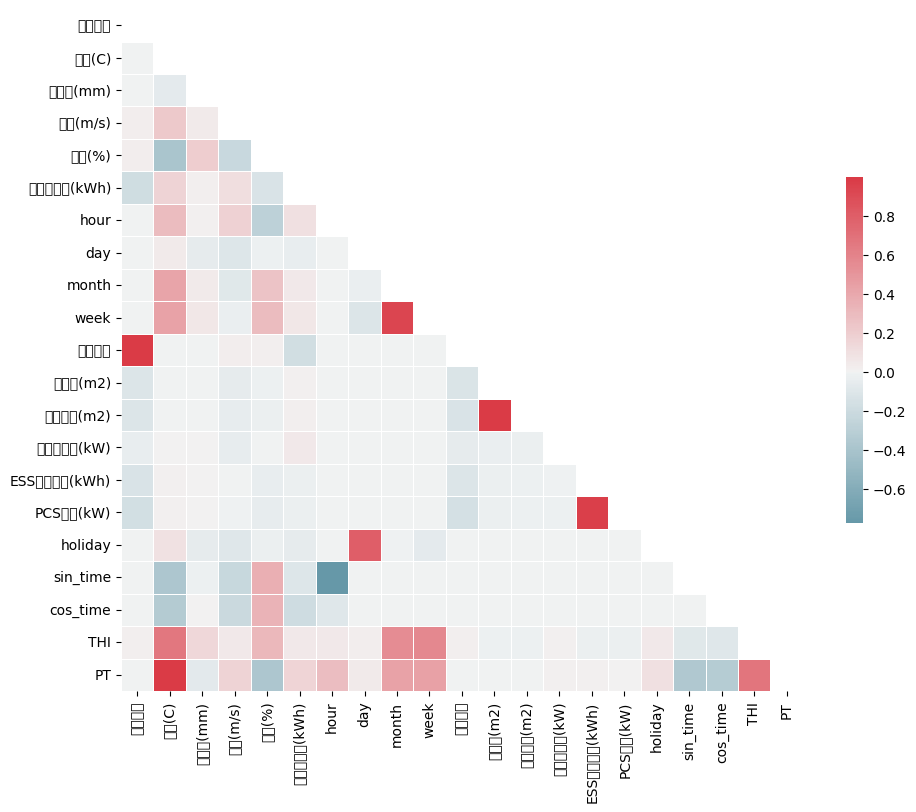

In [ ]:
corr = train_ft.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()


In [ ]:
corr = train_ft.corr().unstack().sort_values(ascending=False).drop_duplicates().drop_duplicates()
corr.drop(corr.index[0],inplace=True)
display(corr.head())
display(corr.tail(5))

냉방면적(m2)      연면적(m2)      0.998884
건물번호          건물유형         0.995019
기온(C)         PT           0.994075
ESS저장용량(kWh)  PCS용량(kW)    0.969688
week          month        0.938039
dtype: float64

sin_time  PT      -0.363584
PT        습도(%)   -0.375264
sin_time  기온(C)   -0.376384
습도(%)     기온(C)   -0.389848
sin_time  hour    -0.775912
dtype: float64

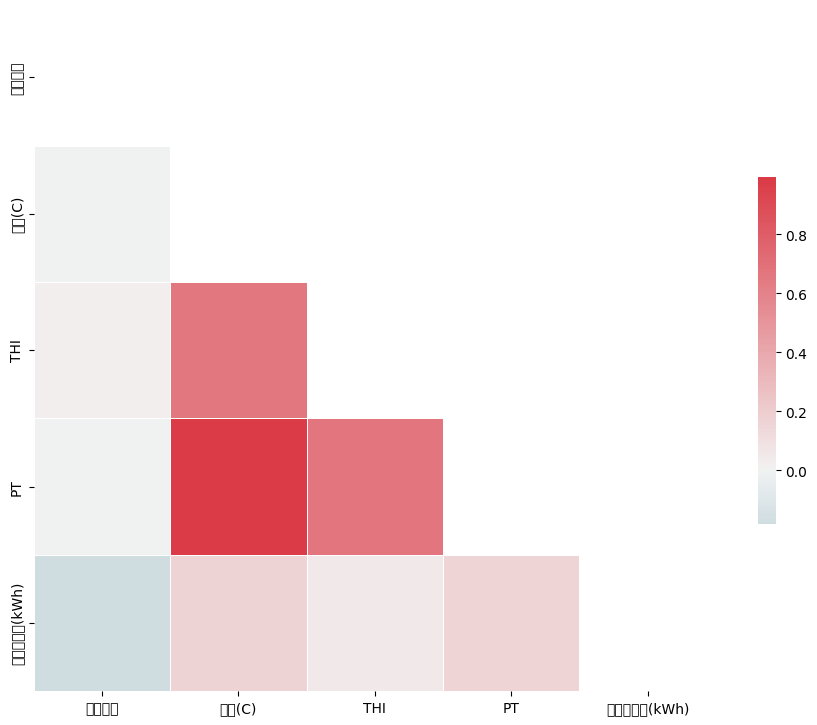

In [ ]:
corr = variabl_train_ft.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [ ]:
corr = variabl_train_ft.corr().unstack().sort_values(ascending=False).drop_duplicates().drop_duplicates()
corr.drop(corr.index[0],inplace=True)
display(corr.head())
display(corr.tail(5))

PT          기온(C)         0.994075
THI         PT            0.672774
기온(C)       THI           0.664382
            전력소비량(kWh)    0.171190
전력소비량(kWh)  PT            0.162818
dtype: float64

전력소비량(kWh)  THI     0.049806
건물번호        THI     0.017665
PT          건물번호   -0.003369
기온(C)       건물번호   -0.004505
전력소비량(kWh)  건물번호   -0.180474
dtype: float64

## 학습을 통한 상관관계분석

In [ ]:
pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107720 sha256=cc41d48078d469a6e33d0df0c37011564ed58583f33a06cdbffeb571c7694833
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.0 MB/s eta 0:00:00


In [ ]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import eli5
from eli5.sklearn import PermutationImportance

import shap

# 학습
## 필요없는 변수 날리는 과정이 .. 전처리 비슷한 것!

In [ ]:
cat_col = ['건물번호', '기온(C)','THI','PT','전력소비량(kWh)'] # 활용할 변수로 수정완료
def lgbm_smape(preds, train_data): # lightGBM 모델 활용 위한 함수
    # labels = train_data.get_label()
    labels = train_data
    smape_val=SMAPE(labels,preds)
    return 'SMAPE', smape_val, False

In [ ]:
reset_seeds(SEED)
models = []
for i in tqdm(range(42,53)):
    print(f"###################[{i}]SEED################################")
    cat_params = {'learning_rate': 0.14059048492476106,
          'loss_function': 'RMSE',
          'random_seed': i,
          'verbose': False,
          'train_dir': 'catboost_1690862972.3436863',
          #  'n_estimators': 2000,
          'n_estimators': 10000,
          #  'early_stopping_rounds': 11,
          'early_stopping_rounds': 100,
          'objective': 'MAE',
          }

    lgbm_params = {'random_state': i,
          'n_estimators': 15000,
          # 'objective' : weighted_mse(100),
          'num_leaves': 8,
          'min_child_samples': 12,
          'learning_rate': 0.17010396907527026,
          'colsample_bytree': 0.9605563464803123,
          'reg_alpha': 0.1110993344544235,
          'reg_lambda': 0.7948637803974561,
          'verbose': -1}
    xgb_params = {'random_state' : i,
          'n_estimators': 4682,
          'max_leaves': 101,
          'min_child_weight': 7.581207558322951,
          'learning_rate': 0.08979034933474227,
          'subsample': 0.8905280196300354,
          'colsample_bylevel': 1.0,
          'colsample_bytree': 0.9523645407001878,
          'reg_alpha': 0.006919296411231538,
          'reg_lambda': 0.0998936254543762}

    CAT_model = CatBoostRegressor(**cat_params)
    LGBM_model = LGBMRegressor(**lgbm_params)
    XGB_model = XGBRegressor(**xgb_params)

    scores = []
    for tri,vai in tqdm(cv.split(train_ft),total=5):
        # 학습데이터
        x_train = train_ft.iloc[tri]
        y_train = target.iloc[tri]

        # 검증데이터
        x_valid = train_ft.iloc[vai]
        y_valid = target.iloc[vai]

        XGB_model.fit(x_train,y_train)
        LGBM_model.fit(x_train,y_train,eval_metric=lgbm_smape,categorical_feature=cat_col,
                   eval_set=(x_valid,y_valid))
        CAT_model.fit(x_train,y_train)

        pred = XGB_model.predict(x_valid)
        pred2 = LGBM_model.predict(x_valid)
        pred3 = CAT_model.predict(x_valid)
        pred = (pred+pred2+pred3)/3

        score = SMAPE(y_valid,pred)
        print(score)
        scores.append(score)
        models.append(XGB_model)
        models.append(LGBM_model)
        models.append(CAT_model)
    print(np.mean(scores))

    # 3시간 48분 소요되었습니다.